In [2]:
include("../../astrobee_se3_script.jl")
using Plots
using JLD2, FileIO
using HDF5
using Keras
using Polynomials
using Statistics
using StatsPlots


# Helper functions

## Main GuSTO function

In [3]:
function solve_gusto(model, N, MAX_ITERATIONS_NB, verbose = true, Xp = [], Up = [])
    
    if (Xp == [] && Up == [])
        Xp,Up = initialize_trajectory(model, N)
    elseif Up == []
        println("GuSTO X has been warm-started.")
        Up = zeros(model.u_dim, N-1)
    else
        if verbose
            println("GuSTO has been warm-started.")
        end
    end
    X, U  = copy(Xp)  , copy(Up) 

    SCPproblem = GuSTOProblem(model, N, Xp, Up)

    x_dim, u_dim = model.x_dim, model.u_dim

    Delta0, omega0, omegamax, 
        epsilon, rho0, rho1, 
        beta_succ, beta_fail, gamma_fail, 
        convergence_threshold = get_initial_gusto_parameters(model)

    Delta = Delta0
    omega = omega0

    X_all, U_all = [], []
    push!(X_all, copy(X))
    push!(U_all, copy(U))

    B_success = false
    it = 0

    while it<MAX_ITERATIONS_NB && 
            !(it!=0 && B_success && 
                convergence_metric(model,X,U,Xp,Up)<convergence_threshold) &&
            omega<omegamax
        if verbose
            println("-----------")
            println("Iteration $it")
            println("metric=$(convergence_metric(model,X,U,Xp,Up))")
            println("-----------")
        end

        Xp = copy(X)
        Up = copy(U)

        model.f, model.A, model.B = compute_dynamics(model, Xp, Up)

        reset_problem(SCPproblem, model)
        set_parameters(SCPproblem, model, Xp, Up, omega, Delta)
        define_cost(SCPproblem, model)
        define_constraints(SCPproblem, model)

        JuMP.optimize!(SCPproblem.solver_model)    

        # get solution
        X_sol = JuMP.value.(SCPproblem.X)
        U_sol = JuMP.value.(SCPproblem.U)

        # -----------
        # GuSTO Logic
        if it > 0
            if is_in_trust_region(model, X_sol, U_sol, Xp, Up, Delta)
                rho = accuracy_ratio(SCPproblem, model, X_sol, U_sol, Xp, Up)

                if rho > rho1
                    if verbose
                        println("Reject solution.")
                    end
                    Delta = beta_fail * Delta
                    omega     = omega
                    B_success = false

                else
                    if verbose
                        println("Accept solution.")
                    end
                    X = copy(X_sol)
                    U = copy(U_sol)
                    B_success = true
                    if rho < rho0
                        Delta = min(beta_succ*Delta, Delta0)
                    else
                        Delta = Delta
                    end
                    if satisfies_state_inequality_constraints(SCPproblem, model, X_sol, U_sol, Xp, Up, Delta)
                        omega = omega0
                    else
                        if verbose
                            println("Solution does not satisfy state constraints, increasing omega.")
                        end
                        omega = gamma_fail * omega
                        B_success = false
                    end
                end
            else
                if verbose
                    println("Reject solution (Outside trust region)")
                end
                Delta = Delta
                omega     = gamma_fail * omega
                B_success = false
            end

        else # always accept first solution
            X = copy(X_sol)
            U = copy(U_sol)
        end


        # -----------

        push!(X_all, copy(X))
        push!(U_all, copy(U))


        it += 1

        diff_with_prev = norm(copy(X) - copy(Xp), Inf)
        if verbose
            println("x(k) - x(k-1) = $diff_with_prev")
            println("Parameters:")
            println("omega=$omega")
            println("delta=$Delta")
        end
    end
    curr_conv_metric = convergence_metric(model,X,U,Xp,Up)
    if (B_success && 
                curr_conv_metric<convergence_threshold)
        if verbose
            println("Converged")
        end
        isConverged = true
    else
        if verbose
            println("Not converged. Metric =$curr_conv_metric")
        end
        isConverged = false
    end
    return isConverged, it, X_all, U_all
end

solve_gusto (generic function with 4 methods)

# GuSTO function that also returns metric

In [4]:
function solve_gusto_return_metric(model, N, MAX_ITERATIONS_NB, verbose = true, Xp = [], Up = [])
    
    if (Xp == [] && Up == [])
        Xp,Up = initialize_trajectory(model, N)
    elseif Up == []
        println("GuSTO X has been warm-started.")
        Up = zeros(model.u_dim, N-1)
    else
        if verbose
            println("GuSTO has been warm-started.")
        end
    end
    X, U  = copy(Xp)  , copy(Up) 

    SCPproblem = GuSTOProblem(model, N, Xp, Up)

    x_dim, u_dim = model.x_dim, model.u_dim

    Delta0, omega0, omegamax, 
        epsilon, rho0, rho1, 
        beta_succ, beta_fail, gamma_fail, 
        convergence_threshold = get_initial_gusto_parameters(model)

    Delta = Delta0
    omega = omega0

    X_all, U_all = [], []
    push!(X_all, copy(X))
    push!(U_all, copy(U))

    B_success = false
    it = 0

    while it<MAX_ITERATIONS_NB && 
            !(it!=0 && B_success && 
                convergence_metric(model,X,U,Xp,Up)<convergence_threshold) &&
            omega<omegamax
        if verbose
            println("-----------")
            println("Iteration $it")
            println("metric=$(convergence_metric(model,X,U,Xp,Up))")
            println("-----------")
        end

        Xp = copy(X)
        Up = copy(U)

        model.f, model.A, model.B = compute_dynamics(model, Xp, Up)

        reset_problem(SCPproblem, model)
        set_parameters(SCPproblem, model, Xp, Up, omega, Delta)
        define_cost(SCPproblem, model)
        define_constraints(SCPproblem, model)

        JuMP.optimize!(SCPproblem.solver_model)    

        # get solution
        X_sol = JuMP.value.(SCPproblem.X)
        U_sol = JuMP.value.(SCPproblem.U)

        # -----------
        # GuSTO Logic
        if it > 0
            if is_in_trust_region(model, X_sol, U_sol, Xp, Up, Delta)
                rho = accuracy_ratio(SCPproblem, model, X_sol, U_sol, Xp, Up)

                if rho > rho1
                    if verbose
                        println("Reject solution.")
                    end
                    Delta = beta_fail * Delta
                    omega     = omega
                    B_success = false

                else
                    if verbose
                        println("Accept solution.")
                    end
                    X = copy(X_sol)
                    U = copy(U_sol)
                    B_success = true
                    if rho < rho0
                        Delta = min(beta_succ*Delta, Delta0)
                    else
                        Delta = Delta
                    end
                    if satisfies_state_inequality_constraints(SCPproblem, model, X_sol, U_sol, Xp, Up, Delta)
                        omega = omega0
                    else
                        if verbose
                            println("Solution does not satisfy state constraints, increasing omega.")
                        end
                        omega = gamma_fail * omega
                        B_success = false
                    end
                end
            else
                if verbose
                    println("Reject solution (Outside trust region)")
                end
                Delta = Delta
                omega     = gamma_fail * omega
                B_success = false
            end

        else # always accept first solution
            X = copy(X_sol)
            U = copy(U_sol)
        end


        # -----------

        push!(X_all, copy(X))
        push!(U_all, copy(U))


        it += 1

        diff_with_prev = norm(copy(X) - copy(Xp), Inf)
        if verbose
            println("x(k) - x(k-1) = $diff_with_prev")
            println("Parameters:")
            println("omega=$omega")
            println("delta=$Delta")
        end
    end
    curr_conv_metric = convergence_metric(model,X,U,Xp,Up)
    if (B_success && 
                curr_conv_metric<convergence_threshold)
        if verbose
            println("Converged")
        end
        isConverged = true
    else
        if verbose
            println("Not converged. Metric =$curr_conv_metric")
        end
        isConverged = false
    end
    return isConverged, it, X_all, U_all, curr_conv_metric
end

solve_gusto_return_metric (generic function with 4 methods)

## Function to check if inside obstacle

In [5]:
function isInsideObstacle(x, model)
    isInside = false
    for obs in model.obstacles
        center = obs[1]
        radius = obs[2]
        if norm(x[1:3] - center) < radius
            isInside = true
            return isInside
        end
    end
    for obs in model.poly_obstacles
        center = obs.c
        dx = obs.dx
        dy = obs.dy
        dz = obs.dz
        x_max = center[1]+dx
        y_max = center[2]+dy
        z_max = center[3]+dz
        x_min = center[1]-dx
        y_min = center[2]-dy
        z_min = center[3]-dz
        if (x[1]<= x_max && x[1] >= x_min && 
            x[2]<= y_max && x[2] >= y_min &&
            x[3]<= z_max && x[3] >= z_min)
            isInside = true
            return isInside
        end
    end
    return isInside
end

isInsideObstacle (generic function with 1 method)

# Plotting functions

In [43]:
function plot_env_and_trajs_three_comp(model, X_all, labls = :None)
    N = length(X_all)
    if N == 3
        if labls == :None
            labls = ["GuSTO solution", "NN prediction", "GuSTO warm-started"]
        end
    elseif labls == :None
        labls = fill("",(size(X_all,1),1))
    end
    idx = [1,2]
#     local fig
#     fig = plot(framestyle = :box)

    for iter = 1:length(X_all)
        X = X_all[iter]
        if iter == 1
            plot!(X[idx[1],:], X[idx[2],:];line=(6, :solid), lab = labls[iter], color = 1)
#             plot!(X[idx[1],:], X[idx[2],:];line=(6, :dash), lab = labls[iter], color = 1)
        elseif iter == 2
            plot!(X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter], color = 2)
            scatter!((X[idx[1],1],X[idx[2],1]), shape = :circle, markersize = 6, color = 2, lab = "")
            scatter!((X[idx[1],end],X[idx[2],end]), shape = :circle, markersize = 6, color = 2, lab = "")
        else
            plot!(X[idx[1],:], X[idx[2],:];line=(6, :dashdot), linealpha = 0.7, lab = labls[iter], color = 3)
            scatter!((X[idx[1],1],X[idx[2],1]), shape = :circle, markersize = 6, color = 3, lab = "")
            scatter!((X[idx[1],end],X[idx[2],end]), shape = :circle, markersize = 6, color = 3, lab = "")
        end        
    end
    
    st_pt = X_all[1][idx[1]:idx[2],1]
    scatter!([st_pt[1]], [st_pt[2]], shape = :circle, markersize = 6, color = :black, lab = "")
    end_pt = X_all[1][idx[1]:idx[2],end]
    scatter!([end_pt[1]], [end_pt[2]], shape = :star, markersize = 8, color = :black, lab = "")
    annotate!([(st_pt[1]-0.4, st_pt[2]+0.4, text("\$x_{init}\$", 22, :black, :left)), 
            (end_pt[1]+0.6, end_pt[2]-0.4, text("\$x_{final}\$", 22, :black, :right))])


    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
    end
    
    for obs_i = 1:length(model.poly_obstacles)
        center =  model.poly_obstacles[obs_i].c
        (c1,c2) = center[idx]
        if idx[1] == 1
            r1 = model.poly_obstacles[obs_i].dx
        elseif idx[1] == 2
            r1 = model.poly_obstacles[obs_i].dy
        else
            r1 = model.poly_obstacles[obs_i].dz
        end
        if idx[2] == 1
            r2 = model.poly_obstacles[obs_i].dx
        elseif idx[2] == 2
            r2 = model.poly_obstacles[obs_i].dy
        else
            r2 = model.poly_obstacles[obs_i].dz
        end
        lab = ""
        color = :red
        buf = 0.2
        r1 = r1-buf
        r2 = r2-buf
        plot!(Shape([(c1-r1,c2-r2), (c1-r1,c2+r2), (c1+r1,c2+r2), (c1+r1, c2-r2)]), seriestype = [:shape,], lw = 0.5,
                c = color, linecolor = :black, linealpha = 0.7,
                fillalpha = 0.5, aspect_ratio = 1, label = lab)
    end
    xlims!((model.x_min[idx[1]],model.x_max[idx[1]]))
    ylims!((model.x_min[idx[2]],model.x_max[idx[2]]))
    plot!(legend = :best, legendfontsize=10)
    plot!(size=(550,550))
    xlabel!("x", guidefontsize = 16)
#     ylabel!("y", guidefontsize = 13)
    annotate!([(-1,5,Plots.text("y",16))])
    plot!(tickfontsize = 12)
    plot!(legendfontsize = 18, fg_legend=:transparent, tickfontsize = 16, guidefontsize = 16, legend=:best,yrotation = 0)
    plot!(gridalpha = 0.2)
#     return fig
end

plot_env_and_trajs_three_comp (generic function with 2 methods)

## Reading and writing to files

In [7]:
function getXYValid(filename)
    f = h5open(filename,"r")
    X_valid_norm = read(f["X_valid_norm"])
    Y_valid_norm = read(f["Y_valid_norm"])
    close(f)
    return (X_valid_norm, Y_valid_norm) 
end


getXYValid (generic function with 1 method)

In [8]:
function getDataParamsFromHDF5Combo(filename)
    f = h5open(filename,"r")
    xMin = read(f["xMin"])
    yMin = read(f["yMin"])
    xRange = read(f["xRange"])
    yRange = read(f["yRange"])
    close(f)
    return (xMin, yMin, xRange, yRange) 
end

getDataParamsFromHDF5Combo (generic function with 1 method)

## Get model on which data was collected and training done

In [9]:
function getModelWithTwoPolyObsOneAtCorner()
    N = 50
    MAX_ITERATIONS_NB = 100

    model = AstrobeeSE3()

    # Set up environment
    model.x_max[1:3] = [10.0; 10.0; 1.0]
    model.x_min[1:3] = [0.0; 0.0; 0.0]

    obstacles = []
    # obs = [[0.0,0.0,0.0], 6.0]
    # push!(obstacles, obs)
    model.obstacles = obstacles

    poly_obstacles = []
    obs = PolygonalObstacle([2.5,2.5,0], [5.0, 5.0, 2.0])
    push!(poly_obstacles, obs)
    obs = PolygonalObstacle([7.0,3.0,0], [1.0, 1.0, 2.0])
    push!(poly_obstacles, obs)
    model.poly_obstacles = poly_obstacles

    model.tf_guess = 110.
    model.convergence_threshold = 5.0 # TODO CHANGED was 2.0
    
    return model
end

getModelWithTwoPolyObsOneAtCorner (generic function with 1 method)

In [10]:
function findTrueGuSTOSolution(x_init, x_final, model = :None, verbose = false, Xinit = [], Uinit = [])
    N = 50
    MAX_ITERATIONS_NB = 200
    
    if model == :None
        println("No model supplied. Using spheres model.")
        model = getModelWithCornerSpheres()
    end
    
    isConverged = false
    X_all = []
    U_all = []
    numIter = 0

    problemNumber = 0

    train_input_collected = Array{Float64}(undef,0,26)
    train_output_collected = Array{Float64}(undef,0,944)

    if isInsideObstacle(x_init, model)
        println("x_init is inside an obstacle. Not valid.")
        return model, isConverged, X_all, U_all
    end
    if isInsideObstacle(x_final, model)
        println("x_final is inside an obstacle. Not valid.")
        return model, isConverged, X_all, U_all
    end
    if norm(x_final[1:3] - x_init[1:3])<1.0
        println("x_init and x_final too close. Not valid.")
        return model, isConverged, X_all, U_all
    end


    model.x_init = x_init
    model.x_final = x_final
    
    if verbose
        println("Starting to solve GuSTO")
    end
    try
        isConverged, numIter, X_all, U_all = solve_gusto(model, N, MAX_ITERATIONS_NB, verbose, Xinit, Uinit)
    catch e
        isConverged = false
        println("$e")
    end
    if verbose
        println("Converged: $isConverged")
    end

    return model, isConverged, numIter, X_all, U_all
end



findTrueGuSTOSolution (generic function with 5 methods)

In [11]:
function findTrueGuSTOSolution_return_metric(x_init, x_final, model = :None, verbose = false, Xinit = [], Uinit = [])
    N = 50
    MAX_ITERATIONS_NB = 200
    
    if model == :None
        println("No model supplied. Using spheres model.")
        model = getModelWithCornerSpheres()
    end
    
    isConverged = false
    X_all = []
    U_all = []
    numIter = 0
    conv_metric = 0

    problemNumber = 0

    train_input_collected = Array{Float64}(undef,0,26)
    train_output_collected = Array{Float64}(undef,0,944)

    if isInsideObstacle(x_init, model)
        println("x_init is inside an obstacle. Not valid.")
        return model, isConverged, X_all, U_all
    end
    if isInsideObstacle(x_final, model)
        println("x_final is inside an obstacle. Not valid.")
        return model, isConverged, X_all, U_all
    end
    if norm(x_final[1:3] - x_init[1:3])<1.0
        println("x_init and x_final too close. Not valid.")
        return model, isConverged, X_all, U_all
    end


    model.x_init = x_init
    model.x_final = x_final
    
    if verbose
        println("Starting to solve GuSTO")
    end
    try
        isConverged, numIter, X_all, U_all, conv_metric = solve_gusto_return_metric(model, N, MAX_ITERATIONS_NB, verbose, Xinit, Uinit)
    catch e
        isConverged = false
        println("$e")
    end
    if verbose
        println("Converged: $isConverged")
    end

    return model, isConverged, numIter, X_all, U_all, conv_metric
end



findTrueGuSTOSolution_return_metric (generic function with 5 methods)

## NN helper functions

In [12]:
function recoverCoeffsfromNNOutput(NN_output, yMin, yRange)
    output_coeffs = (NN_output.*yRange)+yMin    
    return output_coeffs
end

recoverCoeffsfromNNOutput (generic function with 1 method)

In [13]:
function recoverXUfromCoeffs(coeffs)
    N = 50
    tf_guess = 110.
    t_array = range(0,stop=tf_guess,length=N)
    t_minus_one_array = t_array[1:end-1]
    num_coeffs = 5
    x_dim = 13
    u_dim = 6
    
    X_soln = zeros(x_dim, N)
    U_soln = zeros(u_dim, N-1)
    
    for dim = 1:x_dim
        cf_this = coeffs[((dim-1)*num_coeffs + 1): (dim*num_coeffs)]
        this_poly = polyval(Poly(cf_this), t_array)
        X_soln[dim, :] = this_poly
    end
    
    for dim = 1:u_dim
        cf_this = coeffs[(x_dim*num_coeffs + (dim-1)*num_coeffs + 1): (x_dim*num_coeffs + dim*num_coeffs)]
        this_poly = polyval(Poly(cf_this), t_minus_one_array)
        U_soln[dim, :] = this_poly
    end
    
    return X_soln, U_soln
end

recoverXUfromCoeffs (generic function with 1 method)

In [14]:
function recoverXUfromNNOutput(NN_output, yMin, yRange)
    outputCoeffs = recoverCoeffsfromNNOutput(NN_output, yMin, yRange)
    X_soln, U_soln = recoverXUfromCoeffs(outputCoeffs)
end

recoverXUfromNNOutput (generic function with 1 method)

In [15]:
function createNNInput(x_init, x_final, xMin, xRange)
    # x_init and x_goal need to be of size 13
    NN_input = hcat([x_init', x_final']...)'
    NN_input = (NN_input-xMin)./xRange
    return NN_input
end

createNNInput (generic function with 1 method)

In [16]:
function getNNStructureCombo(NNDualParams, NNDualJSON, NNDualWeights)
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(NNDualParams)
    NN = Keras.load(NNDualJSON, NNDualWeights)
    return (NN, xMin, yMin, xRange, yRange)  
end

getNNStructureCombo (generic function with 1 method)

In [17]:
function getNNPredictionCombo(x_init, x_final, NNDualParams, NNDualJSON, NNDualWeights)
    # x_init and x_goal need to be of size 13
    (NN, xMin, yMin, xRange, yRange) = getNNStructureCombo(NNDualParams, NNDualJSON, NNDualWeights)
    NN_input = zeros(1,26)
    NN_input = createNNInput(x_init, x_final, xMin, xRange)
    NN_output = NN(NN_input)
    X_soln, U_soln = recoverXUfromNNOutput(NN_output, yMin, yRange)
    return (X_soln, U_soln)
end

getNNPredictionCombo (generic function with 1 method)

# Get GuSTO to converge in under 5 iterations

In [18]:
filename = "../data_files/PolyComboCoeffsNormalized.jld2"
paramsFileName = "../data_files/PolyComboParams.h5"
(X_valid_norm, Y_valid_norm)  =getXYValid(filename)
X_valid_norm = X_valid_norm'
Y_valid_norm = Y_valid_norm'

1130×95 Adjoint{Float64,Array{Float64,2}}:
 0.00797146  0.512229  0.383065  0.685096  …  0.742335  0.300209  0.544727
 0.225393    0.482636  0.594617  0.565864     0.742343  0.300206  0.544729
 0.648333    0.515476  0.313361  0.715017     0.742343  0.300204  0.544733
 0.00803444  0.506698  0.491006  0.638291     0.742331  0.300213  0.544721
 0.266218    0.504443  0.535339  0.619035     0.742343  0.300204  0.544734
 0.308227    0.505952  0.504961  0.632241  …  0.742342  0.300204  0.544734
 0.861815    0.513748  0.348155  0.700171     0.742343  0.300203  0.544734
 0.541676    0.508441  0.454991  0.653977     0.742342  0.300204  0.544733
 0.859254    0.552225  0.228327  0.649951     0.743208  0.299602  0.545501
 0.349912    0.505349  0.510208  0.56744      0.742343  0.300203  0.544734
 0.0561094   0.502535  0.573817  0.602304  …  0.742342  0.300204  0.544733
 0.8587      0.571439  0.153066  0.854952     0.742224  0.300296  0.544635
 0.266226    0.50364   0.551536  0.611995     0.742342  0

In [19]:
row = 3
@show row
# For the X_valid_norm, pass each to a NN and get the Xsoln, Usoln 
x_v_norm = X_valid_norm[row,:] # size 26
# First convert to X_valid
(xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
x_v = x_v_norm.*xRange + xMin
x_init = x_v[1:13]
x_final = x_v[14:26]
@show x_init
@show x_final
    
model = getModelWithTwoPolyObsOneAtCorner()
# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model, true)
gusto_solve_time = (time_ns() - time_start)/10^9
@show isConverged
@show numIter
@show gusto_solve_time

row = 3
x_init = [6.66667, 4.44444, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
x_final = [5.55556, 7.77778, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Starting to solve GuSTO
-----------
Iteration 0
metric=0.0
-----------

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

x(k) - x(k-1) = 0.34792955357955435
Parameters:
omega=1.0
delta=1000.0
-----------
Iteration 1
metric=3.8409964425637164
-----------
Accept solution.
x(k) - x(k-1) = 0.03277308990554384
Parameters:
omega=1.0
delta=1000.0
Converged
Converged: true
isConverged = true
numIter = 2
gusto_solve_time = 32.094690821


32.094690821

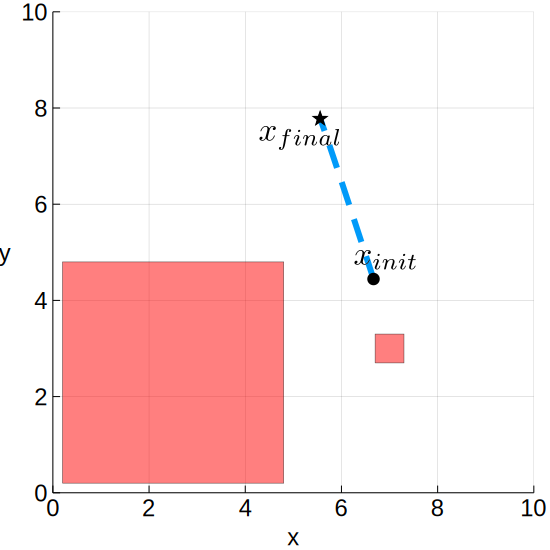

In [20]:
plot()
plot_env_and_trajs_three_comp(model, [X_all_true[end]])

# Get metric without verbose

In [23]:
paramsFileName = "../data_files/PolyComboParams.h5"
row = 20
@show row
# For the X_valid_norm, pass each to a NN and get the Xsoln, Usoln 
x_v_norm = X_valid_norm[row,:] # size 26
# First convert to X_valid
(xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
x_v = x_v_norm.*xRange + xMin
x_init = x_v[1:13]
x_final = x_v[14:26]
@show x_init
@show x_final
    
model = getModelWithTwoPolyObsOneAtCorner()
# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true, conv_metric = findTrueGuSTOSolution_return_metric(x_init, x_final, model, false)
gusto_solve_time = (time_ns() - time_start)/10^9
@show isConverged
@show numIter
@show gusto_solve_time
@show conv_metric

row = 20
x_init = [0.5, 6.125, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
x_final = [9.5, 2.1875, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
isConverged = true
numIter = 4
gusto_solve_time = 2.613266138
conv_metric = 4.696853404102921


4.696853404102921

# Continuing previous

In [17]:
paramsFileName = "../data_files/PolyComboParams.h5"
row = 836
@show row
# For the X_valid_norm, pass each to a NN and get the Xsoln, Usoln 
x_v_norm = X_valid_norm[row,:] # size 26
# First convert to X_valid
(xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
x_v = x_v_norm.*xRange + xMin
x_init = x_v[1:13]
x_final = x_v[14:26]
@show x_init
@show x_final
    
model = getModelWithTwoPolyObsOneAtCorner()
# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model, true)
gusto_solve_time = (time_ns() - time_start)/10^9
@show isConverged
@show numIter
@show gusto_solve_time

row = 836
x_init = [0.9375, 5.8125, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
x_final = [9.5, 1.0625, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Starting to solve GuSTO
-----------
Iteration 0
metric=0.0
-----------
x(k) - x(k-1) = 1.662634942273308
Parameters:
omega=1.0
delta=1000.0
-----------
Iteration 1
metric=18.082569201646216
-----------
Accept solution.
Solution does not satisfy state constraints, increasing omega.
x(k) - x(k-1) = 0.46265196836287936
Parameters:
omega=5.0
delta=1000.0
-----------
Iteration 2
metric=4.862909486199058
-----------
Accept solution.
Solution does not satisfy state constraints, increasing omega.
x(k) - x(k-1) = 0.5709086642947057
Parameters:
omega=25.0
delta=1000.0
-----------
Iteration 3
metric=7.883729913123537
-----------
Accept solution.
Solution does not satisfy state constraints, increasing omega.
x(k) - x(k-1) = 1.565652274193062
Parameters:
omega=125.0
delta=1000.0
-----------
Iteration 4
metric=16.660540826942782
---

6.026795581

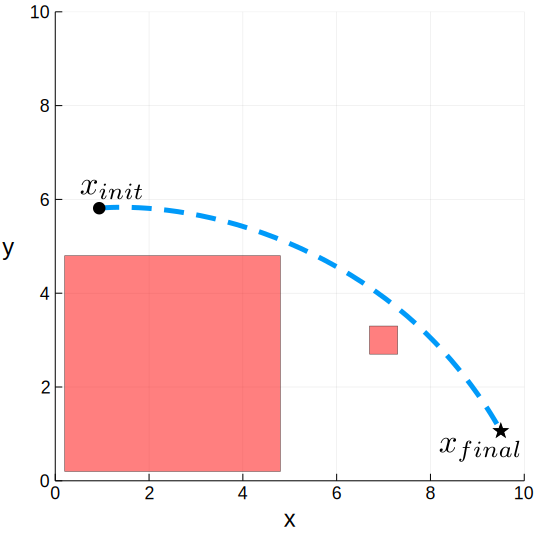

In [18]:
plot()
plot_env_and_trajs_three_comp(model, [X_all_true[end]])

In [18]:
paramsFileName = "../data_files/PolyComboParams.h5"
row = 836
@show row
# For the X_valid_norm, pass each to a NN and get the Xsoln, Usoln 
x_v_norm = X_valid_norm[row,:] # size 26
# First convert to X_valid
(xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
x_v = x_v_norm.*xRange + xMin
x_init = x_v[1:13]
x_final = x_v[14:26]
@show x_init
@show x_final
    
model = getModelWithTwoPolyObsOneAtCorner()
# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model, true)
gusto_solve_time = (time_ns() - time_start)/10^9
@show isConverged
@show numIter
@show gusto_solve_time

row = 836
x_init = [0.9375, 5.8125, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
x_final = [9.5, 1.0625, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Starting to solve GuSTO
-----------
Iteration 0
metric=0.0
-----------

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

x(k) - x(k-1) = 1.662634942273308
Parameters:
omega=1.0
delta=1000.0
-----------
Iteration 1
metric=18.082569201646216
-----------
Accept solution.
Solution does not satisfy state constraints, increasing omega.
x(k) - x(k-1) = 0.46265196836287936
Parameters:
omega=5.0
delta=1000.0
-----------
Iteration 2
metric=4.862909486199058
-----------
Accept solution.
Solution do

39.145430552

In [19]:
plot()
plot_env_and_trajs_three_comp(model, [])

BoundsError: BoundsError: attempt to access 0-element Array{Any,1} at index [1]

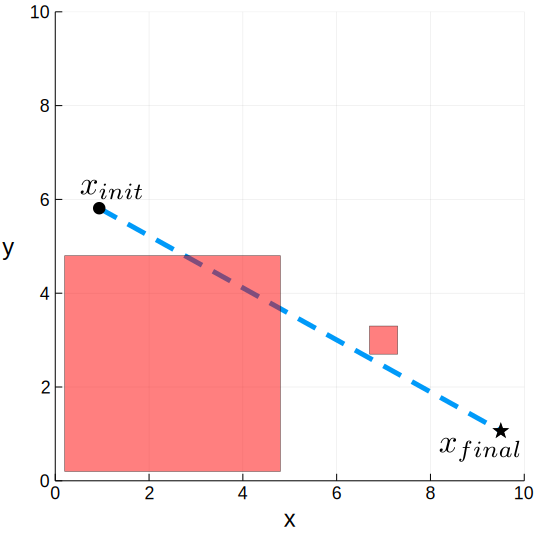

In [23]:
plot()
plot_env_and_trajs_three_comp(model, [X_all_true[1]])

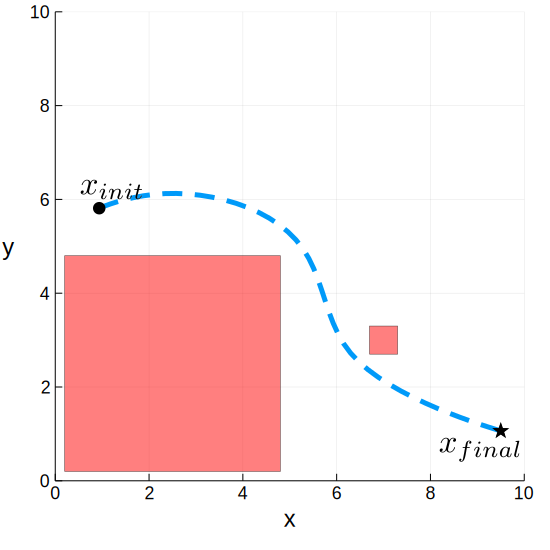

In [21]:
plot()
plot_env_and_trajs_three_comp(model, [X_all_true[2]])

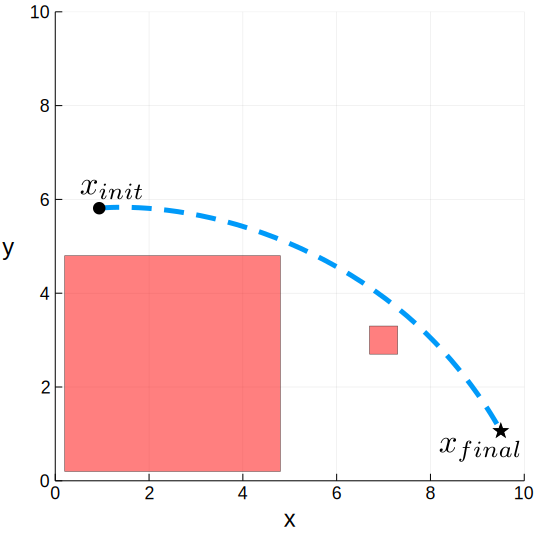

In [22]:
plot()
plot_env_and_trajs_three_comp(model, [X_all_true[end]])

In [29]:
filename = "../data_files/PolyComboCoeffsNormalized.jld2"
paramsFileName = "../data_files/PolyComboParams.h5"
jsonFileName = "../data_files/SimpleAstrobeeTemplate.json"
weightsFileName = "../data_files/PolyComboWeights.h5"
row = 836
@show row
# For the X_valid_norm, pass each to a NN and get the Xsoln, Usoln 
x_v_norm = X_valid_norm[row,:] # size 26
# First convert to X_valid
(xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
x_v = x_v_norm.*xRange + xMin
x_init = x_v[1:13]
x_final = x_v[14:26]
@show x_init
@show x_final
    
model = getModelWithTwoPolyObsOneAtCorner()
# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model, false)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")



row = 836
x_init = [0.9375, 5.8125, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
x_final = [9.5, 1.0625, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
GuSTO solve time = 7.301858003 (9 iterations)
NN_solve_time = 0.005419378
GuSTO warm started solve time = 1.499030122 (2 iterations)


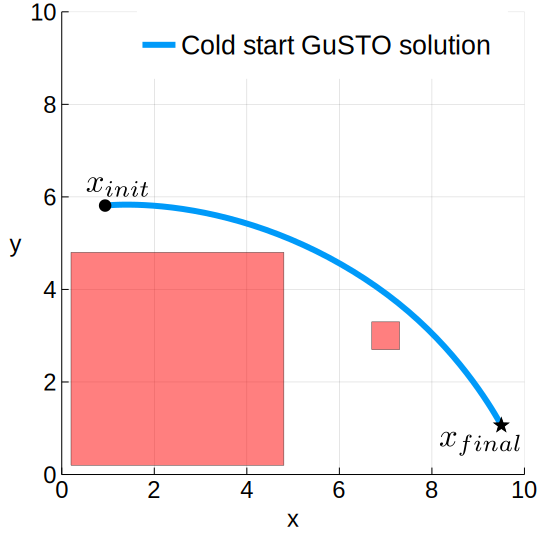

In [47]:
plot()
plot_env_and_trajs_three_comp(model, [X_all_true[end]], ["Cold start GuSTO solution"])

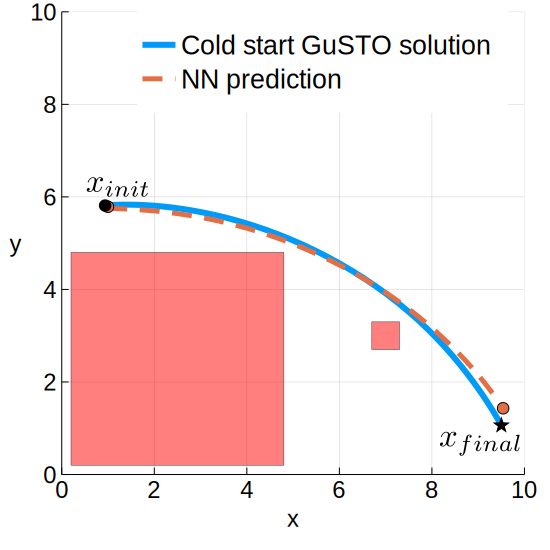

In [48]:
plot()
plot_env_and_trajs_three_comp(model, [X_all_true[end], X_soln_NN], ["Cold start GuSTO solution", "NN prediction",])

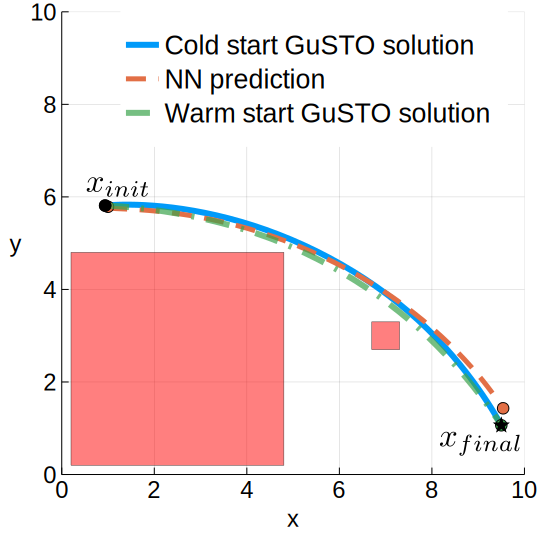

In [49]:
plot()
plot_env_and_trajs_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["Cold start GuSTO solution", "NN prediction", "Warm start GuSTO solution"])

# Compare cold start and warm start GuSTO performance

### Collect the convergence metric, iteration number and times for each

In [55]:
@show size(X_valid_norm,1)

size(X_valid_norm, 1) = 1130


1130

In [56]:
x_dim = 13
u_dim = 6
num_coeffs = 5

filename = "../data_files/PolyComboCoeffsNormalized.jld2"
paramsFileName = "../data_files/PolyComboParams.h5"
jsonFileName = "../data_files/SimpleAstrobeeTemplate.json"
weightsFileName = "../data_files/PolyComboWeights.h5"
(X_valid_norm, Y_valid_norm)  =getXYValid(filename)
X_valid_norm = X_valid_norm'
Y_valid_norm = Y_valid_norm'
# @show size(X_valid_norm)
# @show size(Y_valid_norm)

# num_data_to_collect = size(X_valid_norm,1) # default
num_data_to_collect = 1130

cold_start_data = zeros(num_data_to_collect, 4)
# NOTE: cold_start_data[row,:] = [converged?, num_iter, solve_time, conv_metric]

warm_start_data = zeros(num_data_to_collect, 4)
# NOTE: warm_start_data[row,:] = [converged?, num_iter, solve_time, conv_metric]

NN_run_data = zeros(num_data_to_collect,1)
# NOTE: NN_run_data[row,:] = NN_solve_time

row = 0
for counter in 1:size(X_valid_norm,1)/num_data_to_collect:size(X_valid_norm,1)
    row = row + 1
# for row in 3:4
    @show row
    # For the X_valid_norm, pass each to a NN and get the Xsoln, Usoln 
    x_v_norm = X_valid_norm[row,:] # size 26
    # First convert to X_valid
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
    x_v = x_v_norm.*xRange + xMin
    x_init = x_v[1:13]
    x_final = x_v[14:26]
    
    model = getModelWithTwoPolyObsOneAtCorner()

    # GuSTO solution time and trajectory
    time_start = time_ns()
    model, isConverged, numIter, X_all_true, U_all_true, conv_metric_true = findTrueGuSTOSolution_return_metric(x_init, x_final, model, false)
    gusto_solve_time = (time_ns() - time_start)/10^9
    cold_start_data[row,:]= [isConverged, numIter, gusto_solve_time, conv_metric_true]
#     println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

    # NN prediction time and trajectory
    time_start = time_ns()
    X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
    NN_solve_time = (time_ns() - time_start)/10^9
    NN_run_data[row,1]= NN_solve_time
#     @show NN_solve_time

    # GuSTO warm start solution time and trajectory
    time_start = time_ns()
    model, isConverged, numIter_warm, X_all_warm, U_all_warm, conv_metric_warm  = findTrueGuSTOSolution_return_metric(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
    gusto_warm_solve_time = (time_ns() - time_start)/10^9
    warm_start_data[row,:]= [isConverged, numIter_warm, gusto_warm_solve_time, conv_metric_warm]
#     println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")
    
    println("")


    if mod(row,10) == 0
        @save "../data_files/coldstartwarmstartdataWithMetric.jld2" cold_start_data warm_start_data NN_run_data
        println("Intermediate save")
        println("")
    end
end
@save "../data_files/coldstartwarmstartdataWithMetric.jld2" cold_start_data warm_start_data NN_run_data
print("All GuSTO warm start, cold start and NN run times are saved")            

row = 1

row = 2

row = 3

row = 4

row = 5

row = 6

row = 7

row = 8

row = 9

row = 10

Intermediate save

row = 11

row = 12

row = 13

row = 14

row = 15

row = 16

row = 17

row = 18

row = 19

row = 20

Intermediate save

row = 21

row = 22

row = 23

row = 24

row = 25

row = 26

row = 27

row = 28

row = 29

row = 30

Intermediate save

row = 31

row = 32

row = 33

row = 34

row = 35

row = 36

row = 37

row = 38

row = 39

row = 40

Intermediate save

row = 41

row = 42

row = 43

row = 44

row = 45

row = 46

row = 47

row = 48

row = 49

row = 50

Intermediate save

row = 51

row = 52

row = 53

row = 54

row = 55

row = 56

row = 57

row = 58

row = 59

row = 60

Intermediate save

row = 61

row = 62

row = 63

row = 64

row = 65

row = 66

row = 67

row = 68

row = 69

row = 70

Intermediate save

row = 71

row = 72

row = 73

row = 74

row = 75

row = 76

row = 77

row = 78

row = 79

row = 80

Intermediate save

row = 81

row = 82

row = 83

row = 84

row = 85

row = 8


row = 646

row = 647

row = 648

row = 649

row = 650

Intermediate save

row = 651

row = 652

row = 653

row = 654

row = 655

row = 656

row = 657

row = 658

row = 659

row = 660

Intermediate save

row = 661

row = 662

row = 663

row = 664

row = 665

row = 666

row = 667

row = 668

row = 669

row = 670

Intermediate save

row = 671

row = 672

row = 673

row = 674

row = 675

row = 676

row = 677

row = 678

row = 679

row = 680

Intermediate save

row = 681

row = 682

row = 683

row = 684

row = 685

row = 686

row = 687

row = 688

row = 689

row = 690

Intermediate save

row = 691

row = 692

row = 693

row = 694

row = 695

row = 696

row = 697

row = 698

row = 699

row = 700

Intermediate save

row = 701

row = 702

row = 703

row = 704

row = 705

row = 706

row = 707

row = 708

row = 709

row = 710

Intermediate save

row = 711

row = 712

row = 713

row = 714

row = 715

row = 716

row = 717

row = 718

row = 719

row = 720

Intermediate save

row = 721

row = 722



# Plotting convergence metric for each

In [57]:
@load "../data_files/coldstartwarmstartdataWithMetric.jld2" cold_start_data warm_start_data NN_run_data
cold_conv = cold_start_data[:,1]
warm_conv = warm_start_data[:,1]
@show size(cold_start_data)

size(cold_start_data) = (1130, 4)


(1130, 4)

In [58]:
for row = 1:size(cold_start_data,1)
    if warm_conv[row] == 0.0
        println("didn't converge")
        @show warm_start_data[row,2]
        continue;
    end
end


didn't converge
warm_start_data[row, 2] = 14.0


In [59]:
w = warm_start_data
c = cold_start_data
w_filt = [w[i,:] for i=1:size(w,1) if w[i,1]==1 && c[i,1]==1]
c_filt = [c[i,:] for i=1:size(c,1) if w[i,1]==1 && c[i,1]==1]
c_filt = Array(hcat(c_filt...)')
w_filt = Array(hcat(w_filt...)')

1126×4 Array{Float64,2}:
 1.0   3.0  1.7314   0.00583777 
 1.0   4.0  2.44887  1.6316     
 1.0   2.0  1.21024  0.00117557 
 1.0   2.0  1.15706  5.6951e-5  
 1.0   2.0  1.17606  0.00267256 
 1.0   2.0  1.16781  0.000111208
 1.0   2.0  1.1297   0.00582251 
 1.0   2.0  1.39374  1.18242e-5 
 1.0   4.0  2.69044  4.07324    
 1.0   2.0  1.21177  5.11444e-5 
 1.0   5.0  3.08429  0.233895   
 1.0   2.0  1.12318  9.4236e-5  
 1.0   2.0  1.11414  0.196793   
 ⋮                              
 1.0   2.0  1.15772  0.0685399  
 1.0  10.0  6.35666  3.10788    
 1.0   2.0  1.12395  6.45501e-5 
 1.0   2.0  1.26793  0.000363472
 1.0   2.0  1.51707  0.000121525
 1.0   3.0  2.03493  4.0428     
 1.0   2.0  1.14738  7.1478e-5  
 1.0   2.0  1.15648  1.3445     
 1.0   2.0  1.18328  2.40001    
 1.0   4.0  2.5606   1.59102    
 1.0   2.0  1.28237  3.00782    
 1.0   2.0  1.14113  0.000144153

# Compile statistics

In [60]:
warm_iter = w_filt[:,2]
cold_iter = c_filt[:,2]
@show mean(warm_iter)
@show mean(cold_iter)
@show std(warm_iter)
@show std(cold_iter)
@show maximum(warm_iter)
@show maximum(cold_iter)

mean(warm_iter) = 3.4937833037300177
mean(cold_iter) = 4.1696269982238015
std(warm_iter) = 4.533280047052133
std(cold_iter) = 5.361807426882116
maximum(warm_iter) = 85.0
maximum(cold_iter) = 56.0


56.0

In [61]:
warm_conv_metric = w_filt[:,4]
cold_conv_metric = c_filt[:,4]
@show mean(warm_conv_metric)
@show mean(cold_conv_metric)
@show std(warm_conv_metric)
@show std(cold_conv_metric)
@show maximum(warm_conv_metric)
@show maximum(cold_conv_metric)

mean(warm_conv_metric) = 0.7988902918926554
mean(cold_conv_metric) = 1.0479369442040591
std(warm_conv_metric) = 1.3684131509855828
std(cold_conv_metric) = 1.5883303868452685
maximum(warm_conv_metric) = 4.958050060899814
maximum(cold_conv_metric) = 4.99939537712999


4.99939537712999

In [62]:
warm_iter_only_large_iter = [warm_iter[i] for i=1:size(warm_iter,1) if cold_iter[i]>=10]
cold_iter_only_large_iter = [cold_iter[i] for i=1:size(warm_iter,1) if cold_iter[i]>=10]
@show mean(warm_iter_only_large_iter)
@show mean(cold_iter_only_large_iter)
@show std(warm_iter_only_large_iter)
@show std(cold_iter_only_large_iter)
@show maximum(warm_iter_only_large_iter)
@show maximum(cold_iter_only_large_iter)

mean(warm_iter_only_large_iter) = 8.978494623655914
mean(cold_iter_only_large_iter) = 17.817204301075268
std(warm_iter_only_large_iter) = 11.691671594161875
std(cold_iter_only_large_iter) = 10.6505217636622
maximum(warm_iter_only_large_iter) = 85.0
maximum(cold_iter_only_large_iter) = 56.0


56.0

In [63]:
warm_conv_metric_only_large_iter = [warm_conv_metric[i] for i=1:size(warm_iter,1) if cold_iter[i]>=10]
cold_conv_metric_only_large_iter = [cold_conv_metric[i] for i=1:size(warm_iter,1) if cold_iter[i]>=10]
@show mean(warm_conv_metric_only_large_iter)
@show mean(cold_conv_metric_only_large_iter)
@show std(warm_conv_metric_only_large_iter)
@show std(cold_conv_metric_only_large_iter)
@show maximum(warm_conv_metric_only_large_iter)
@show maximum(cold_conv_metric_only_large_iter)

mean(warm_conv_metric_only_large_iter) = 1.87350922606617
mean(cold_conv_metric_only_large_iter) = 2.0307780963825275
std(warm_conv_metric_only_large_iter) = 1.569509492479102
std(cold_conv_metric_only_large_iter) = 1.6791937398805457
maximum(warm_conv_metric_only_large_iter) = 4.915609698141871
maximum(cold_conv_metric_only_large_iter) = 4.9492649832469455


4.9492649832469455

### Collect the iteration number and times for each

In [ ]:
x_dim = 13
u_dim = 6
num_coeffs = 5

filename = "../data_files/PolyComboCoeffsNormalized.jld2"
paramsFileName = "../data_files/PolyComboParams.h5"
jsonFileName = "../data_files/SimpleAstrobeeTemplate.json"
weightsFileName = "../data_files/PolyComboWeights.h5"
(X_valid_norm, Y_valid_norm)  =getXYValid(filename)
X_valid_norm = X_valid_norm'
Y_valid_norm = Y_valid_norm'
# @show size(X_valid_norm)
# @show size(Y_valid_norm)

cold_start_data = zeros(size(X_valid_norm,1), 3)
# NOTE: cold_start_data[row,:] = [converged?, num_iter, solve_time]

warm_start_data = zeros(size(X_valid_norm,1), 3)
# NOTE: warm_start_data[row,:] = [converged?, num_iter, solve_time]

NN_run_data = zeros(size(X_valid_norm,1),1)
# NOTE: NN_run_data[row,:] = NN_solve_time

for row in 1:size(X_valid_norm,1)
# for row in 3:4
    @show row
    # For the X_valid_norm, pass each to a NN and get the Xsoln, Usoln 
    x_v_norm = X_valid_norm[row,:] # size 26
    # First convert to X_valid
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
    x_v = x_v_norm.*xRange + xMin
    x_init = x_v[1:13]
    x_final = x_v[14:26]
    
    model = getModelWithTwoPolyObsOneAtCorner()

    # GuSTO solution time and trajectory
    time_start = time_ns()
    model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model, false)
    gusto_solve_time = (time_ns() - time_start)/10^9
    cold_start_data[row,:]= [isConverged, numIter, gusto_solve_time]
    println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

    # NN prediction time and trajectory
    time_start = time_ns()
    X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
    NN_solve_time = (time_ns() - time_start)/10^9
    NN_run_data[row,1]= NN_solve_time
    @show NN_solve_time

    # GuSTO warm start solution time and trajectory
    time_start = time_ns()
    model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
    gusto_warm_solve_time = (time_ns() - time_start)/10^9
    warm_start_data[row,:]= [isConverged, numIter_warm, gusto_warm_solve_time]
    println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")
    
    println("")

#     plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])

    
    
    
#     # NN prediction time and trajectory
#     NN_coeffs = getNNCoeffsCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
# #     @show size(NN_coeffs)

#     # For the Y_valid_norm, these are 95 coefficients
#     y_v_norm = Y_valid_norm[row,:] # size 95
#     # First convert to Y_valid
#     (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
#     true_coeffs = y_v_norm.*yRange + yMin
# #     @show size(true_coeffs)

#     for dim in 1:(x_dim+u_dim)
#         true_cf_this = true_coeffs[((dim-1)*num_coeffs + 1): (dim*num_coeffs)]
#         NN_cf_this = NN_coeffs[((dim-1)*num_coeffs + 1): (dim*num_coeffs)]
#         true_coeffs_matrix[row,dim,:] = true_cf_this
#         NN_coeffs_matrix[row,dim,:] = NN_cf_this
#     end
    if mod(row,10) == 0
        @save "../data_files/coldstartwarmstartdataAdjusted2.jld2" cold_start_data warm_start_data NN_run_data
        println("Intermediate save")
        println("")
    end
end
@save "../data_files/coldstartwarmstartdataAdjusted2.jld2" cold_start_data warm_start_data NN_run_data
print("All GuSTO warm start, cold start and NN run times are saved")            

## Plotting cold and warm start data

In [57]:
@load "../data_files/coldstartwarmstartdataAdjusted2.jld2" cold_start_data warm_start_data NN_run_data


3-element Array{Symbol,1}:
 :cold_start_data
 :warm_start_data
 :NN_run_data    

In [58]:
@show size(cold_start_data)
cold_conv = cold_start_data[:,1]
@show extrema(cold_conv)
warm_conv = warm_start_data[:,1]
@show extrema(warm_conv)

size(cold_start_data) = (1130, 3)
extrema(cold_conv) = (0.0, 1.0)
extrema(warm_conv) = (0.0, 1.0)


(0.0, 1.0)

In [59]:
for row = 1:size(cold_start_data,1)
    if warm_conv[row] == 0.0
        println("didn't converge")
        @show warm_start_data[row,2]
        continue;
    end
end


didn't converge
warm_start_data[row, 2] = 14.0


In [60]:
w = warm_start_data
c = cold_start_data
w_filt = [w[i,:] for i=1:size(w,1) if w[i,1]==1 && c[i,1]==1]
c_filt = [c[i,:] for i=1:size(c,1) if w[i,1]==1 && c[i,1]==1]
c_filt = Array(hcat(c_filt...)')
w_filt = Array(hcat(w_filt...)')

1126×3 Array{Float64,2}:
 1.0   3.0  1.78391
 1.0   4.0  2.58304
 1.0   2.0  1.18452
 1.0   2.0  1.16918
 1.0   2.0  1.14935
 1.0   2.0  1.20847
 1.0   2.0  1.11386
 1.0   2.0  1.34338
 1.0   4.0  2.6314 
 1.0   2.0  1.47252
 1.0   5.0  3.22767
 1.0   2.0  1.08601
 1.0   2.0  1.10655
 ⋮                 
 1.0   2.0  1.33996
 1.0  10.0  6.27821
 1.0   2.0  1.13792
 1.0   2.0  1.28613
 1.0   2.0  1.2568 
 1.0   3.0  1.81884
 1.0   2.0  1.38491
 1.0   2.0  1.16627
 1.0   2.0  1.15663
 1.0   4.0  2.29744
 1.0   2.0  1.27694
 1.0   2.0  1.14147

# Compile statistics

In [61]:
warm_iter = w_filt[:,2]
cold_iter = c_filt[:,2]
@show mean(warm_iter)
@show mean(cold_iter)
@show std(warm_iter)
@show std(cold_iter)
@show maximum(warm_iter)
@show maximum(cold_iter)

mean(warm_iter) = 3.4937833037300177
mean(cold_iter) = 4.1696269982238015
std(warm_iter) = 4.533280047052133
std(cold_iter) = 5.361807426882116
maximum(warm_iter) = 85.0
maximum(cold_iter) = 56.0


56.0

In [62]:
warm_iter = w_filt[:,2]
cold_iter = c_filt[:,2]
@show mean(warm_iter)
@show mean(cold_iter)
warm_time = w_filt[:,3]
cold_time = c_filt[:,3]
@show mean(warm_time)
@show mean(cold_time)

mean(warm_iter) = 3.4937833037300177
mean(cold_iter) = 4.1696269982238015
mean(warm_time) = 2.1493459158303727
mean(cold_time) = 2.570112536706927


2.570112536706927

mean(cold_iter) = 4.1696269982238015
mean(warm_iter) = 3.4937833037300177
median(cold_iter) = 2.0
median(warm_iter) = 2.0
size(diff_iter) = (1126, 2)


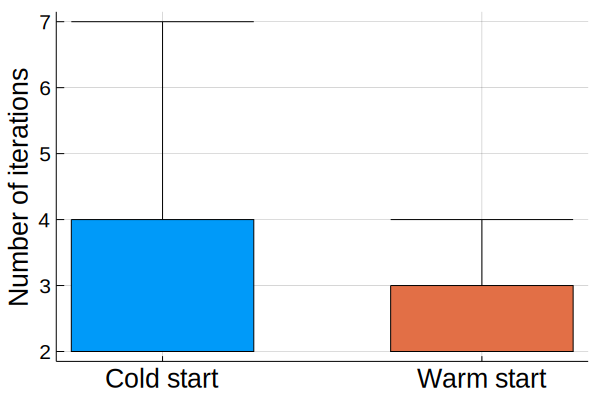

In [63]:
diff_iter = zeros(size(w_filt,1),2)
diff_iter[:,1] = cold_iter
diff_iter[:,2] = warm_iter
@show mean(cold_iter)
@show mean(warm_iter)
@show median(cold_iter)
@show median(warm_iter)

@show size(diff_iter)
boxplot(["Cold start" "Warm start"],diff_iter,leg=false; outliers= false)
plot!(yaxis="Number of iterations")
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, guidefontsize = 18)
# title!("Difference between warm start and cold start iterations")


In [64]:
png("coldvswarmiterations.png")

mean(diff_iter[:, 1]) = 2.570112536706927
mean(diff_iter[:, 2]) = 2.1493459158303727
size(diff_iter) = (1126, 2)


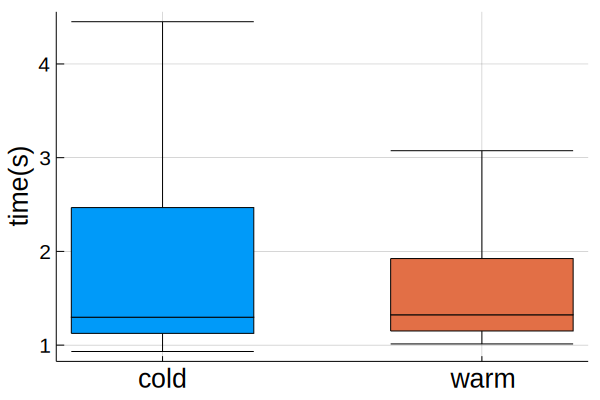

In [65]:
diff_iter = zeros(size(w_filt,1),2)
diff_iter[:,1] = cold_time
diff_iter[:,2] = warm_time
@show mean(diff_iter[:,1])
@show mean(diff_iter[:,2])

@show size(diff_iter)
boxplot(["cold" "warm"],diff_iter,leg=false; outliers= false)
plot!(yaxis="time(s)")
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, guidefontsize = 18)
# title!("Difference between warm start and cold start iterations")


In [66]:
diff_iter = cold_iter - warm_iter
count(x->x==0.0,diff_iter)
# count(x->x<0.0,diff_iter)

701

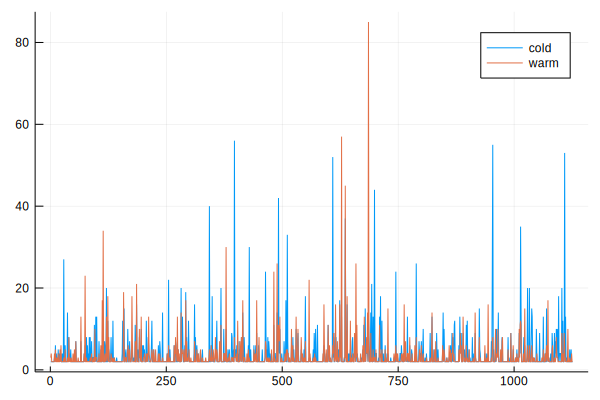

In [67]:
xs = 1:size(w_filt,1)
plot(xs, cold_iter,label="cold")
plot!(xs, warm_iter, label = "warm")


# Sort and filter out the array outliers and then statistics

In [112]:
cold_iter_filt_outliers = sort(cold_iter, rev=true)
warm_iter_filt_outliers = sort(warm_iter, rev=true)


1126-element Array{Float64,1}:
 85.0
 57.0
 45.0
 34.0
 30.0
 26.0
 26.0
 24.0
 23.0
 22.0
 21.0
 19.0
 18.0
  ⋮  
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0

In [114]:
cold_iter_filt_outliers = sort(cold_iter, rev=true)[4:end]
warm_iter_filt_outliers = sort(warm_iter, rev=true)[4:end]


1123-element Array{Float64,1}:
 34.0
 30.0
 26.0
 26.0
 24.0
 23.0
 22.0
 21.0
 19.0
 18.0
 18.0
 18.0
 17.0
  ⋮  
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0

In [115]:
@show mean(warm_iter_filt_outliers)
@show mean(cold_iter_filt_outliers)
@show std(warm_iter_filt_outliers)
@show std(cold_iter_filt_outliers)
@show maximum(warm_iter_filt_outliers)
@show maximum(cold_iter_filt_outliers)

mean(warm_iter_filt_outliers) = 3.33659839715049
mean(cold_iter_filt_outliers) = 4.034728406055209
std(warm_iter_filt_outliers) = 3.2515957697415816
std(cold_iter_filt_outliers) = 4.68886168264046
maximum(warm_iter_filt_outliers) = 34.0
maximum(cold_iter_filt_outliers) = 52.0


52.0

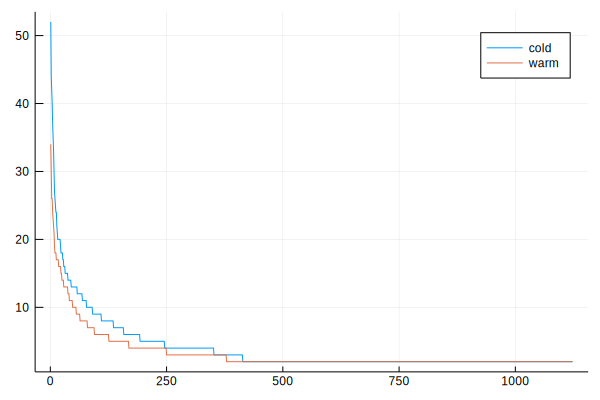

In [116]:
xs = 1:size(warm_iter_filt_outliers,1)
plot(xs, cold_iter_filt_outliers,label="cold")
plot!(xs, warm_iter_filt_outliers, label = "warm")


# Only greater than 10 iterations

In [117]:
w_filt_large_iter = [w_filt[i,:] for i=1:size(w_filt,1) if c_filt[i,2]>=10]
c_filt_large_iter = [c_filt[i,:] for i=1:size(c_filt,1) if c_filt[i,2]>=10]
c_filt_large_iter = Array(hcat(c_filt_large_iter...)')
w_filt_large_iter = Array(hcat(w_filt_large_iter...)')
@show size(w_filt_large_iter)
@show size(c_filt_large_iter)

size(w_filt_large_iter) = (93, 3)
size(c_filt_large_iter) = (93, 3)


(93, 3)

# Compile statistics

In [118]:
w_large_iterats = w_filt_large_iter[:,2]
c_large_iterats = c_filt_large_iter[:,2]
@show mean(w_large_iterats)
@show mean(c_large_iterats)
@show std(w_large_iterats)
@show std(c_large_iterats)
@show maximum(w_large_iterats)
@show maximum(c_large_iterats)

mean(w_large_iterats) = 8.978494623655914
mean(c_large_iterats) = 17.817204301075268
std(w_large_iterats) = 11.691671594161875
std(c_large_iterats) = 10.6505217636622
maximum(w_large_iterats) = 85.0
maximum(c_large_iterats) = 56.0


56.0

# Sort and filter out the array outliers and then statistics

In [119]:
cold_iter_filt_large_outliers = sort(c_large_iterats, rev=true)[4:end]
warm_iter_filt_large_outliers = sort(w_large_iterats, rev=true)[4:end]
# cold_iter_filt_large_outliers = sort(c_large_iterats, rev=true)[3:end]
# warm_iter_filt_large_outliers = sort(w_large_iterats, rev=true)[3:end]

90-element Array{Float64,1}:
 30.0
 26.0
 24.0
 21.0
 18.0
 18.0
 17.0
 17.0
 16.0
 14.0
 14.0
 13.0
 13.0
  ⋮  
  3.0
  3.0
  3.0
  3.0
  3.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0

In [120]:
@show mean(warm_iter_filt_large_outliers)
@show mean(cold_iter_filt_large_outliers)
@show std(warm_iter_filt_large_outliers)
@show std(cold_iter_filt_large_outliers)
@show maximum(warm_iter_filt_large_outliers)
@show maximum(cold_iter_filt_large_outliers)

mean(warm_iter_filt_large_outliers) = 7.2
mean(cold_iter_filt_large_outliers) = 16.58888888888889
std(warm_iter_filt_large_outliers) = 5.716524441073725
std(cold_iter_filt_large_outliers) = 8.361084877250935
maximum(warm_iter_filt_large_outliers) = 30.0
maximum(cold_iter_filt_large_outliers) = 52.0


52.0

mean(diff_iter[:, 1]) = 17.817204301075268
mean(diff_iter[:, 2]) = 8.978494623655914
median(diff_iter[:, 1]) = 14.0
median(diff_iter[:, 2]) = 5.0
size(diff_iter) = (93, 2)


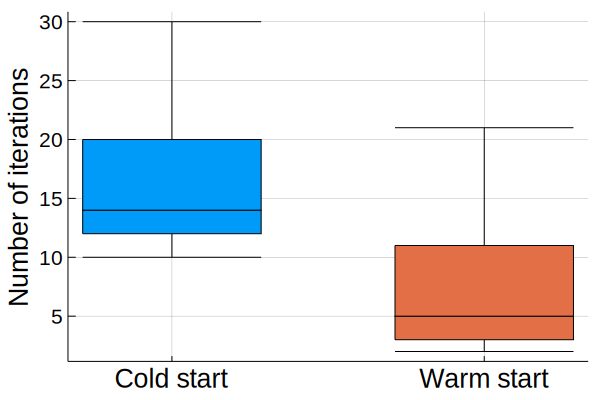

In [121]:
diff_iter = zeros(size(w_filt_large_iter,1),2)
diff_iter[:,1] = c_filt_large_iter[:,2]
diff_iter[:,2] = w_filt_large_iter[:,2]
@show mean(diff_iter[:,1])
@show mean(diff_iter[:,2])
@show median(diff_iter[:,1])
@show median(diff_iter[:,2])

@show size(diff_iter)
boxplot(["Cold start" "Warm start"],diff_iter,leg=false; outliers= false)
plot!(yaxis="Number of iterations")
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, guidefontsize = 18)
# title!("Difference between warm start and cold start iterations")


In [122]:
png("coldvswarm_greaterthan10iterations.png")

In [123]:
w_filt_large_iter = [w_filt[i,:] for i=1:size(w_filt,1) if c_filt[i,2]>6]
c_filt_large_iter = [c_filt[i,:] for i=1:size(c_filt,1) if c_filt[i,2]>6]
c_filt_large_iter = Array(hcat(c_filt_large_iter...)')
w_filt_large_iter = Array(hcat(w_filt_large_iter...)')
@show size(w_filt_large_iter)
@show size(c_filt_large_iter)

size(w_filt_large_iter) = (160, 3)
size(c_filt_large_iter) = (160, 3)


(160, 3)

mean(diff_iter[:, 1]) = 13.6875
mean(diff_iter[:, 2]) = 7.6625
median(diff_iter[:, 1]) = 10.5
median(diff_iter[:, 2]) = 5.0
size(diff_iter) = (160, 2)


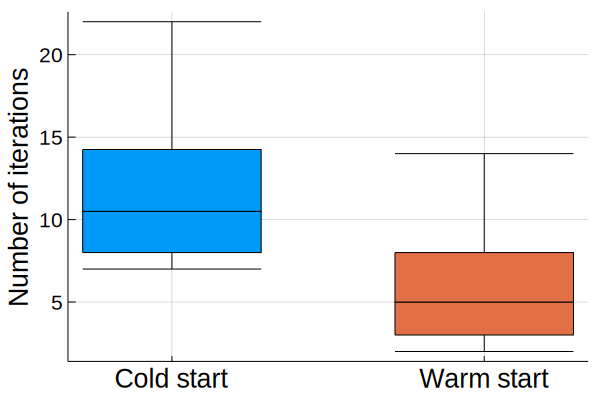

In [87]:
diff_iter = zeros(size(w_filt_large_iter,1),2)
diff_iter[:,1] = c_filt_large_iter[:,2]
diff_iter[:,2] = w_filt_large_iter[:,2]
@show mean(diff_iter[:,1])
@show mean(diff_iter[:,2])
@show median(diff_iter[:,1])
@show median(diff_iter[:,2])

@show size(diff_iter)
boxplot(["Cold start" "Warm start"],diff_iter,leg=false; outliers= false)
plot!(yaxis="Number of iterations")
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, guidefontsize = 18)
# title!("Difference between warm start and cold start iterations")


In [88]:
png("coldvswarm_greaterthan6iterations.png")

In [89]:
# Plot all three trajs

In [ ]:
paramsFileName = "../data_files/PolyComboParams.h5"
row = 836
@show row
# For the X_valid_norm, pass each to a NN and get the Xsoln, Usoln 
x_v_norm = X_valid_norm[row,:] # size 26
# First convert to X_valid
(xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
x_v = x_v_norm.*xRange + xMin
x_init = x_v[1:13]
x_final = x_v[14:26]
@show x_init
@show x_final
    
model = getModelWithTwoPolyObsOneAtCorner()
# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model, true)
gusto_solve_time = (time_ns() - time_start)/10^9
@show isConverged
@show numIter
@show gusto_solve_time

In [ ]:
plot()
plot_env_and_trajs_three_comp(model, [X_all_true[end]])

# Plot four different types of trajectories and show warm start vs. cold start performance

In [139]:
x_start= [0.9375, 8.0, 0.5]
x_goal = [7.5, 2.1875, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]


# GuSTO solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "../data_files/PolyComboParams.h5"
jsonFileName = "../data_files/SimpleAstrobeeTemplate.json"
weightsFileName = "../data_files/PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")



GuSTO solve time = 12.281873905 (13 iterations)
NN_solve_time = 0.193682733
GuSTO warm started solve time = 2.386322501 (3 iterations)


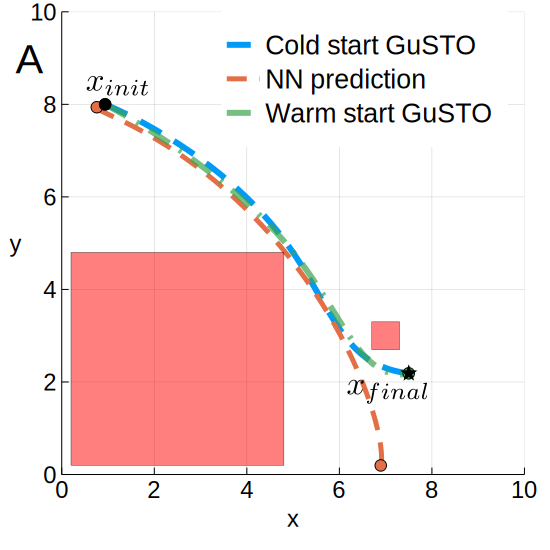

In [140]:
plot()
plot_env_and_trajs_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["Cold start GuSTO", "NN prediction", "Warm start GuSTO"])
annotate!([(-1.0,9.0, text("A", 28, :black, :left))])

In [110]:
png("warmcoldA")

In [141]:
x_start= [6.0, 1.0, 0.5]
x_goal = [7.5, 5., 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]


# GuSTO solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "../data_files/PolyComboParams.h5"
jsonFileName = "../data_files/SimpleAstrobeeTemplate.json"
weightsFileName = "../data_files/PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")



GuSTO solve time = 1.876306648 (2 iterations)
NN_solve_time = 0.032690108
GuSTO warm started solve time = 3.777514949 (5 iterations)


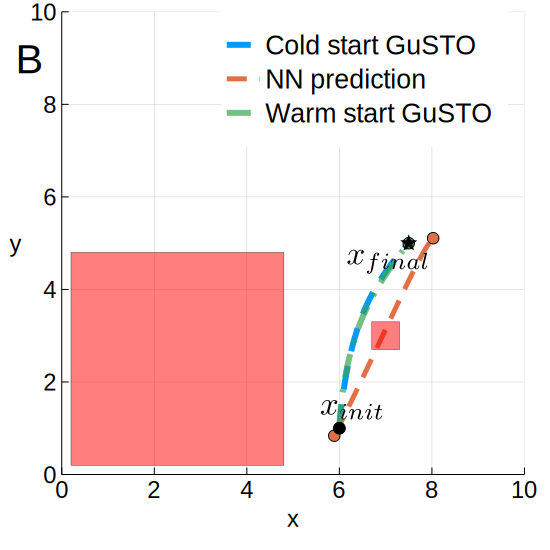

In [142]:
plot()
plot_env_and_trajs_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["Cold start GuSTO", "NN prediction", "Warm start GuSTO"])
annotate!([(-1.0,9.0, text("B", 28, :black, :left))])

In [113]:
png("warmcoldB")

In [143]:
x_start= [0.5, 6.0, 0.5]
x_goal = [9.0, 1., 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]


# GuSTO solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "../data_files/PolyComboParams.h5"
jsonFileName = "../data_files/SimpleAstrobeeTemplate.json"
weightsFileName = "../data_files/PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")



GuSTO solve time = 34.47276761 (38 iterations)
NN_solve_time = 0.003557945
GuSTO warm started solve time = 10.163854898 (13 iterations)


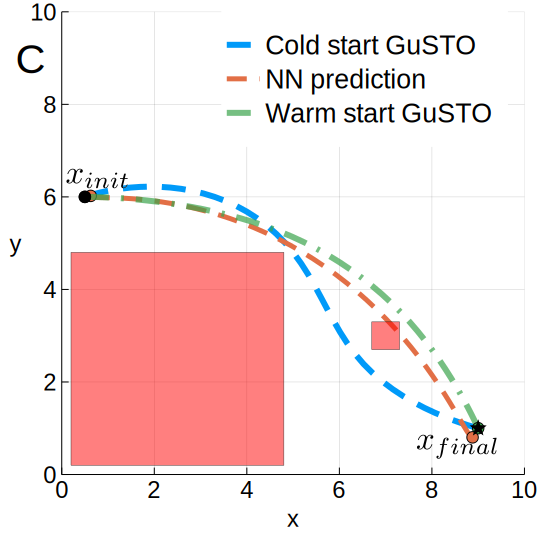

In [144]:
plot()
plot_env_and_trajs_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["Cold start GuSTO", "NN prediction", "Warm start GuSTO"])
annotate!([(-1.0,9.0, text("C", 28, :black, :left))])

In [145]:
x_start= [2.0, 6.0, 0.5]
x_goal = [9.0, 1., 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]


# GuSTO solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "../data_files/PolyComboParams.h5"
jsonFileName = "../data_files/SimpleAstrobeeTemplate.json"
weightsFileName = "../data_files/PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")



GuSTO solve time = 10.431849233 (11 iterations)
NN_solve_time = 0.005927445
GuSTO warm started solve time = 1.947896984 (2 iterations)


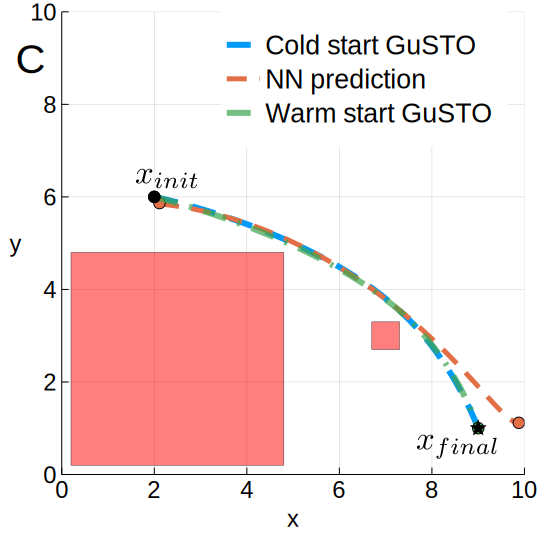

In [146]:
plot()
plot_env_and_trajs_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["Cold start GuSTO", "NN prediction", "Warm start GuSTO"])
annotate!([(-1.0,9.0, text("C", 28, :black, :left))])

In [118]:
png("warmcoldC")

In [147]:
x_start= [8.0, 1.0, 0.5]
x_goal = [5.0, 6., 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]


# GuSTO solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "../data_files/PolyComboParams.h5"
jsonFileName = "../data_files/SimpleAstrobeeTemplate.json"
weightsFileName = "../data_files/PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")



GuSTO solve time = 13.138125711 (15 iterations)
NN_solve_time = 0.01184789
GuSTO warm started solve time = 7.98952393 (9 iterations)


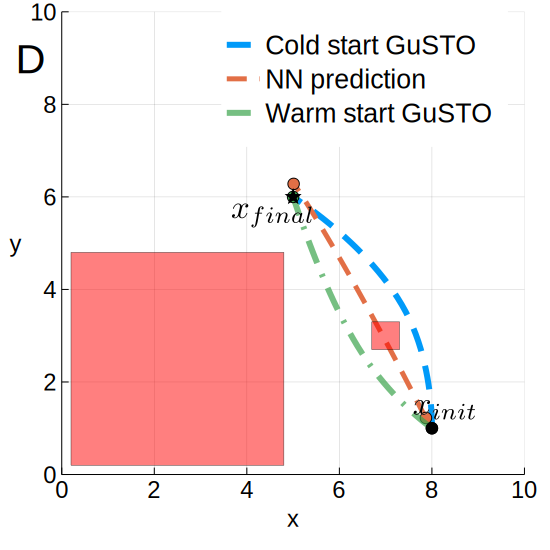

In [148]:
plot()
plot_env_and_trajs_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["Cold start GuSTO", "NN prediction", "Warm start GuSTO"])
annotate!([(-1.0,9.0, text("D", 28, :black, :left))])

In [149]:
x_start= [7.8, 1.0, 0.5]
x_goal = [5.0, 6., 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]


# GuSTO solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "../data_files/PolyComboParams.h5"
jsonFileName = "../data_files/SimpleAstrobeeTemplate.json"
weightsFileName = "../data_files/PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")



GuSTO solve time = 4.547196006 (5 iterations)
NN_solve_time = 0.013419984
GuSTO warm started solve time = 3.923989211 (5 iterations)


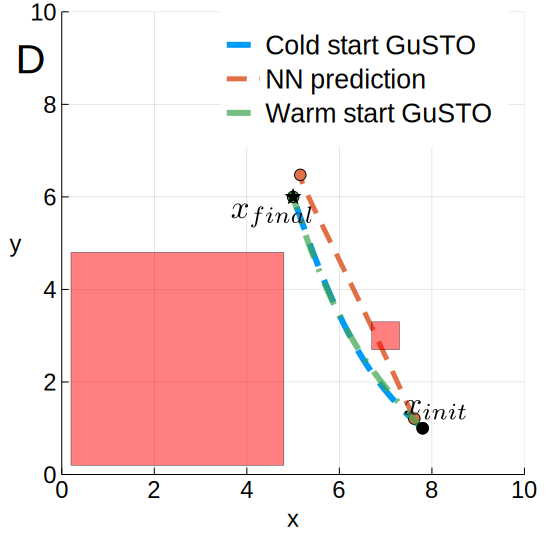

In [150]:
plot()
plot_env_and_trajs_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["Cold start GuSTO", "NN prediction", "Warm start GuSTO"])
annotate!([(-1.0,9.0, text("D", 28, :black, :left))])

In [123]:
png("warmcoldD")

# New plot for presentation

In [18]:
x_start= [0.5, 7.0, 0.5]
x_goal = [6.0, 2.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]


# GuSTO solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "../data_files/PolyComboParams.h5"
jsonFileName = "../data_files/SimpleAstrobeeTemplate.json"
weightsFileName = "../data_files/PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")




******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

GuSTO solve time = 47.3689956 (13 iterations)
NN_solve_time = 5.353608914
GuSTO warm started solve time = 1.288157131 (2 iterations)


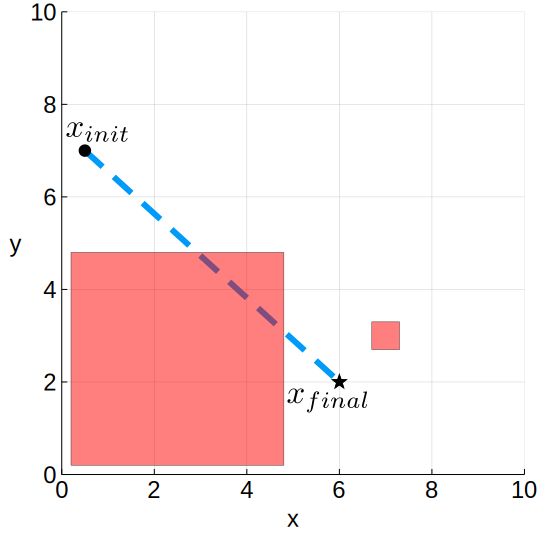

In [36]:
plot()
plot_env_and_trajs_three_comp(model, [X_all_true[1]], [""])


In [38]:
png("pres_stline")

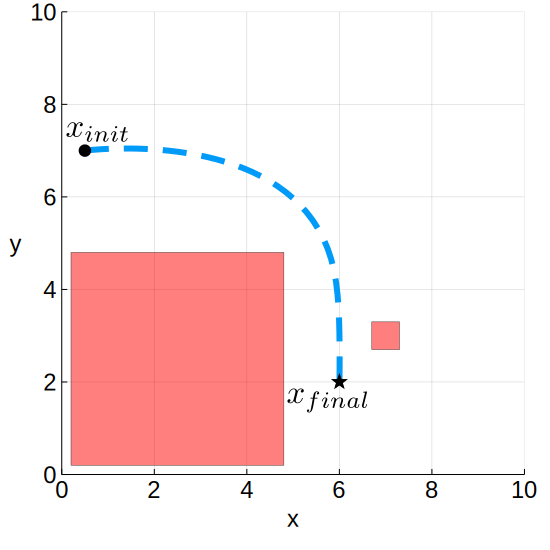

In [39]:
plot()
plot_env_and_trajs_three_comp(model, [X_all_true[4]], [""])


In [40]:
png("pres_firstiter")

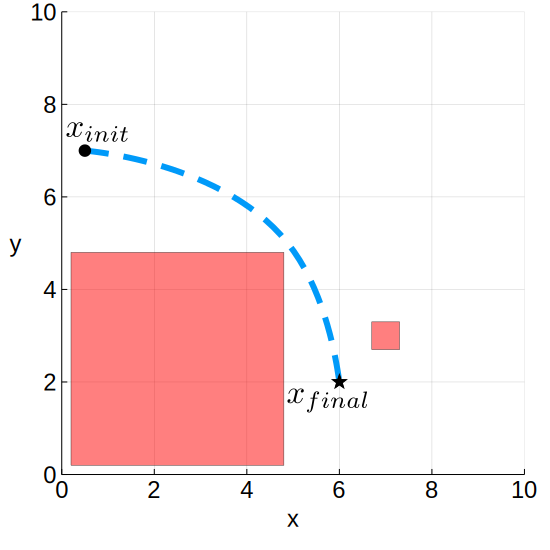

In [41]:
plot()
plot_env_and_trajs_three_comp(model, [X_all_true[end]], [""])


In [42]:
png("pres_convCold")

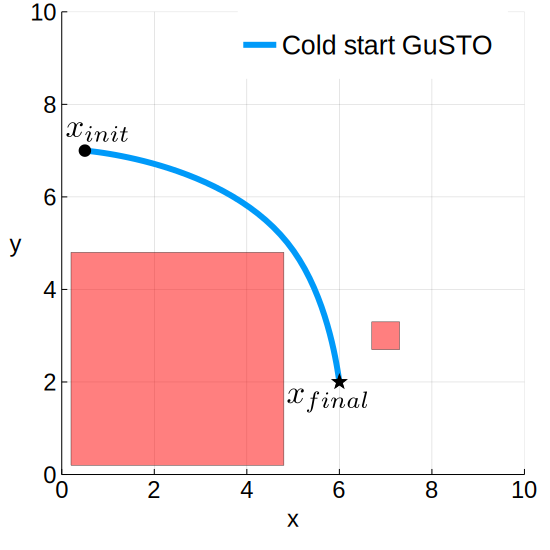

In [44]:
plot()
plot_env_and_trajs_three_comp(model, [X_all_true[end]], ["Cold start GuSTO"])


In [45]:
png("pres_solidCold")

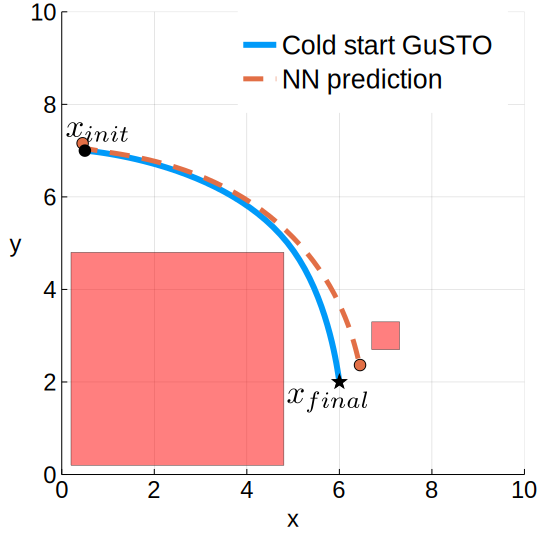

In [46]:
plot()
plot_env_and_trajs_three_comp(model, [X_all_true[end], X_soln_NN], ["Cold start GuSTO", "NN prediction"])
# annotate!([(-1.0,9.0, text("D", 28, :black, :left))])

In [47]:
png("pres_solidColdAndNNPred")

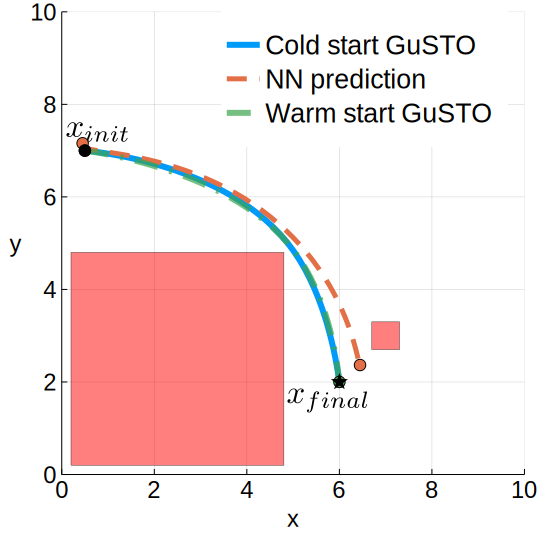

In [49]:
plot()
plot_env_and_trajs_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["Cold start GuSTO", "NN prediction", "Warm start GuSTO"])
# annotate!([(-1.0,9.0, text("D", 28, :black, :left))])

In [50]:
png("pres_allThree")

# Try new obstacles that are unseen before

In [178]:
function add_new_obs_and_plot(x_start, x_goal,obs, addtimes = true)
    x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
    x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
    model = getModelWithTwoPolyObsOneAtCorner()
    model.convergence_threshold = 5.0

    # NN original prediction time and trajectory
    paramsFileName = "../data_files/PolyComboParams.h5"
    jsonFileName = "../data_files/SimpleAstrobeeTemplate.json"
    weightsFileName = "../data_files/PolyComboWeights.h5"
    time_start = time_ns()
    X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
    NN_solve_time = (time_ns() - time_start)/10^9
    @show NN_solve_time


    # Add an extra obstacle
#     poly_obstacles = []
#     obs = PolygonalObstacle([5.5,1.5,0.5], [0.5, 0.5, 2.0])
    for o in obs
        push!(model.poly_obstacles, o)
    end


    # GuSTO solution time and trajectory- COLD START
    time_start = time_ns()
    model, isConverged, numIter, X_all_new_cold, U_all_new_cold = findTrueGuSTOSolution(x_init, x_final, model)
    gusto_solve_time = (time_ns() - time_start)/10^9
    println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

    # GuSTO start solution time and trajectory- WARM START
    time_start = time_ns()
    model, isConverged, numIter_warm, X_all_new_warm, U_all_new_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
    gusto_warm_solve_time = (time_ns() - time_start)/10^9
    println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")
    
    if addtimes
        labls = ["Straight line initialization", "GuSTO cold start ($numIter iterations, $gusto_solve_time seconds)", "NN initialization", "GuSTO warm-started ($numIter_warm iterations, $gusto_warm_solve_time seconds)"]
    else
        labls = ["Straight line initialization", "GuSTO cold start", "NN initialization", "GuSTO warm-started"]
    end
    X_straight = hcat(range(x_init, stop=x_final, length=50)...)
    
    X_all = [X_straight, X_all_new_cold[end], X_soln_NN,   X_all_new_warm[end]]
    
    N = length(X_all)
    idx = [1,2]
#     local fig
#     fig = plot(framestyle = :box)
    p1 = plot()
    
    for iter = 1:length(X_all)
        X = X_all[iter]
        if iter == 1                 
            plot!(X[idx[1],:], X[idx[2],:];line=(5, :dot), lab = labls[iter], color = 1)
        elseif iter == 2
            plot!(X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter], color = 1)
            scatter!((X[idx[1],1],X[idx[2],1]), shape = :circle, markersize = 6, color = 1, lab = "")
            scatter!((X[idx[1],end],X[idx[2],end]), shape = :circle, markersize = 6, color = 1, lab = "")
        elseif iter ==3
            plot!(X[idx[1],:], X[idx[2],:];line=(5, :dot), lab = labls[iter], color = 3)
        elseif iter ==4
            plot!(X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter], color = 3)
            scatter!((X[idx[1],1],X[idx[2],1]), shape = :circle, markersize = 6, color = 3, lab = "")
            scatter!((X[idx[1],end],X[idx[2],end]), shape = :circle, markersize = 6, color = 3, lab = "")
        end        
    end
    
    
    
    
#     for iter = 1:length(X_all)
#         X = X_all[iter]
#         if iter == 1
#             plot!(X[idx[1],:], X[idx[2],:];line=(6, :dash), lab = labls[iter], color = 1)
#         elseif iter == 2
#             plot!(X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter], color = 2)
#             scatter!((X[idx[1],1],X[idx[2],1]), shape = :circle, markersize = 6, color = 2, lab = "")
#             scatter!((X[idx[1],end],X[idx[2],end]), shape = :circle, markersize = 6, color = 2, lab = "")
#         else
#             plot!(X[idx[1],:], X[idx[2],:];line=(6, :dashdot), linealpha = 0.7, lab = labls[iter], color = 3)
#             scatter!((X[idx[1],1],X[idx[2],1]), shape = :circle, markersize = 6, color = 3, lab = "")
#             scatter!((X[idx[1],end],X[idx[2],end]), shape = :circle, markersize = 6, color = 3, lab = "")
#         end        
#     end
    
    st_pt = X_all[1][idx[1]:idx[2],1]
    scatter!([st_pt[1]], [st_pt[2]], shape = :circle, markersize = 6, color = :black, lab = "")
    end_pt = X_all[1][idx[1]:idx[2],end]
    scatter!([end_pt[1]], [end_pt[2]], shape = :star, markersize = 8, color = :black, lab = "")
    annotate!([(st_pt[1]-0.4, st_pt[2]+0.4, text("\$x_{init}\$", 22, :black, :left)), 
            (end_pt[1]+0.4, end_pt[2]-0.4, text("\$x_{final}\$", 22, :black, :right))])


    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
    end
    
    for obs_i = 1:length(model.poly_obstacles)
        center =  model.poly_obstacles[obs_i].c
        (c1,c2) = center[idx]
        if idx[1] == 1
            r1 = model.poly_obstacles[obs_i].dx
        elseif idx[1] == 2
            r1 = model.poly_obstacles[obs_i].dy
        else
            r1 = model.poly_obstacles[obs_i].dz
        end
        if idx[2] == 1
            r2 = model.poly_obstacles[obs_i].dx
        elseif idx[2] == 2
            r2 = model.poly_obstacles[obs_i].dy
        else
            r2 = model.poly_obstacles[obs_i].dz
        end
        lab = ""
        color = :red
        buf = 0.1
        r1 = r1-buf
        r2 = r2-buf
        plot!(Shape([(c1-r1,c2-r2), (c1-r1,c2+r2), (c1+r1,c2+r2), (c1+r1, c2-r2)]), seriestype = [:shape,], lw = 0.5,
                c = color, linecolor = :black, linealpha = 0.7,
                fillalpha = 0.5, aspect_ratio = 1, label = lab)
    end
    xlims!((model.x_min[idx[1]],model.x_max[idx[1]]))
    ylims!((model.x_min[idx[2]],model.x_max[idx[2]]))
    plot!(legend = :best, legendfontsize=10)
    plot!(size=(600,600))
    xlabel!("x", guidefontsize = 16)
#     ylabel!("y", guidefontsize = 13)
    annotate!([(-1,5,Plots.text("y",16))])
    plot!(tickfontsize = 12)
    plot!(legendfontsize = 18, fg_legend=:transparent, tickfontsize = 16, guidefontsize = 16, legend=:best,yrotation = 0)
    plot!(gridalpha = 0.2)    
    
    return p1
end

add_new_obs_and_plot (generic function with 2 methods)

NN_solve_time = 0.005466612
GuSTO solve time = 2.962138401 (4 iterations)
GuSTO warm started solve time = 4.7809367 (7 iterations)


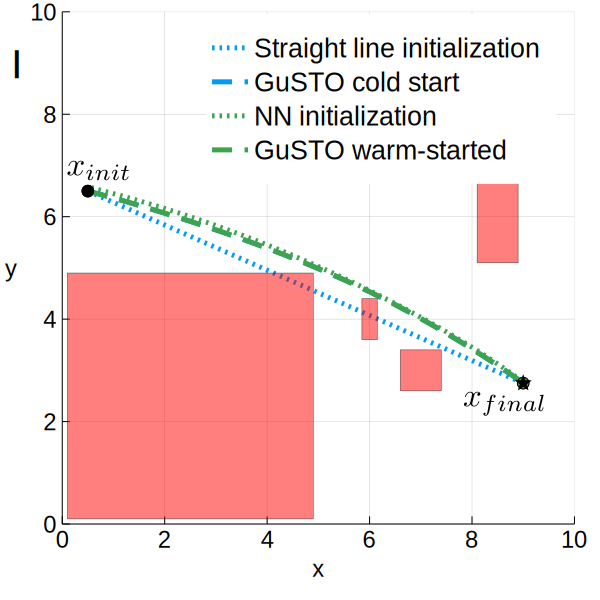

In [194]:
x_start= [0.5, 6.5, 0.5]
x_goal = [9., 2.75, 0.5]
extraobs = [PolygonalObstacle([6.0,4.0,0.5], [0.5, 1.0, 2.0]),PolygonalObstacle([8.5,6.5,0.5], [1.0, 3.0, 2.0])]
p1 = add_new_obs_and_plot(x_start, x_goal,extraobs,false)
annotate!([(-1.0,9.0, text("I", 28, :black, :left))])

In [195]:
png("newobs_1.png")

NN_solve_time = 0.011425327
GuSTO solve time = 1.253514055 (2 iterations)
GuSTO warm started solve time = 2.571113421 (4 iterations)


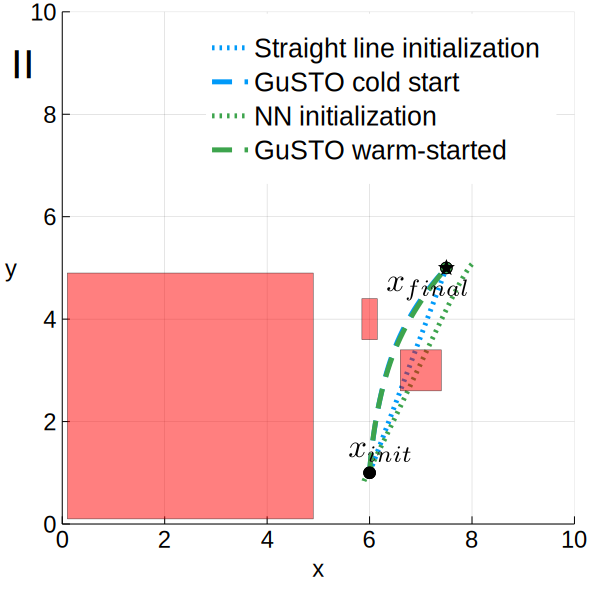

In [196]:
x_start= [6.0, 1.0, 0.5]
x_goal = [7.5, 5., 0.5]
extraobs = [PolygonalObstacle([6.0,4.0,0.5], [0.5, 1.0, 2.0])]
p2 = add_new_obs_and_plot(x_start, x_goal,extraobs,false)
annotate!([(-1.0,9.0, text("II", 28, :black, :left))])

In [197]:
png("newobs_2.png")

NN_solve_time = 0.004169518
GuSTO solve time = 13.394672222 (19 iterations)
GuSTO warm started solve time = 4.038976908 (6 iterations)


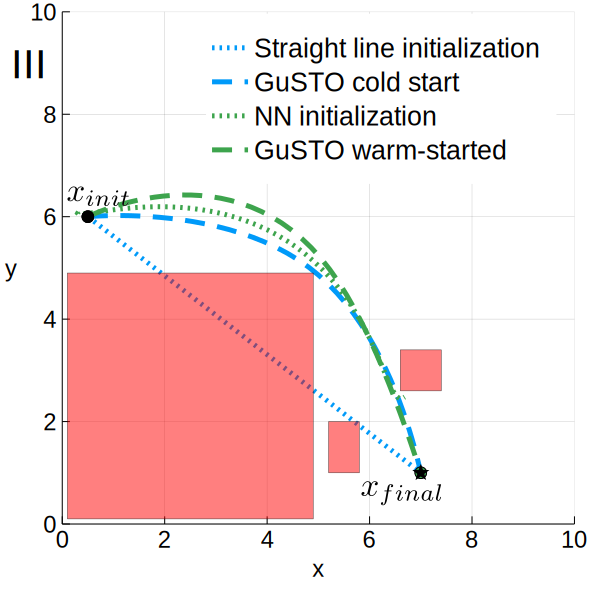

In [198]:
x_start= [0.5, 6.0, 0.5]
x_goal = [7.0, 1., 0.5]
extraobs = [PolygonalObstacle([5.5,1.5,0.5], [0.8, 1.2, 2.0])]
p3=add_new_obs_and_plot(x_start, x_goal,extraobs, false)
annotate!([(-1.0,9.0, text("III", 28, :black, :left))])

In [199]:
png("newobs_3.png")

NN_solve_time = 0.00895393
GuSTO solve time = 3.499474587 (5 iterations)
GuSTO warm started solve time = 3.152691032 (5 iterations)


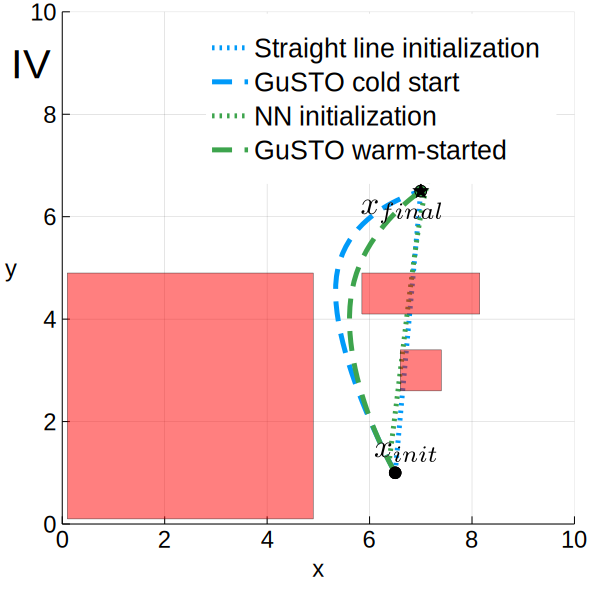

In [200]:
x_start = [6.5, 1., 0.5]
x_goal = [7.0, 6.5, 0.5]
extraobs = [PolygonalObstacle([7.0,4.5,0.5], [2.5, 1.0, 2.0])]
p4=add_new_obs_and_plot(x_start, x_goal,extraobs, false)
annotate!([(-1.0,9.0, text("IV", 28, :black, :left))])

In [201]:
png("newobs_4.png")